# IMPORT LIBRARY

In [330]:
# Data Manipulation and Graph
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import os


# Modelling
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error


In [331]:
df= pd.read_csv('csv/Regresi A5_final.csv')
df.head(10)

,tahun,bulan,tanggal,stasiun,karbon_monoksida
0,2024,1,1,DKI5 Kebon Jeruk Jakarta Barat,18.0
1,2024,1,2,DKI5 Kebon Jeruk Jakarta Barat,9.0
2,2024,1,3,DKI5 Kebon Jeruk Jakarta Barat,7.0
3,2024,1,4,DKI5 Kebon Jeruk Jakarta Barat,10.0
4,2024,1,5,DKI5 Kebon Jeruk Jakarta Barat,15.0
5,2024,1,6,DKI5 Kebon Jeruk Jakarta Barat,12.0
6,2024,1,7,DKI5 Kebon Jeruk Jakarta Barat,23.0
7,2024,1,8,DKI5 Kebon Jeruk Jakarta Barat,12.0
8,2024,1,9,DKI5 Kebon Jeruk Jakarta Barat,18.0
9,2024,1,10,DKI5 Kebon Jeruk Jakarta Barat,11.0


# DATA SPLITTING

In [332]:
def data_spliting (percent):
    df = pd.read_csv('csv/Regresi A5_final.csv')
    split_point = int(len(df) * percent)
    train = df[:split_point]
    test = df[split_point:]

    file_path_train = os.path.join('csv', f'data_train_{percent}.csv')
    file_path_test = os.path.join('csv', f'data_test_{percent}.csv')

    train.to_csv(file_path_train, index=False)
    test.to_csv(file_path_test, index=False)
    
data_spliting(0.7) #70%
data_spliting(0.8) #80%

# MODEL TRAINING

In [333]:
def create_dataset(series, time_step=4, feature_name="karbon_monoksida", recent_first=True):
    """
    series: array/list 1D atau 2D
    recent_first=True  -> kolom: [lag1=t-1, lag2=t-2, ...]
    recent_first=False -> kolom: [t-4, t-3, t-2, t-1] (seperti punyamu sekarang)
    """
    s = np.asarray(series).ravel()
    X, y = [], []
    for i in range(len(s) - time_step):
        window = s[i:i+time_step]               # [t-4, t-3, t-2, t-1] Testing
        if recent_first:
            window = window[::-1]               # balik: [t-1, t-2, t-3, t-4]
        X.append(window)
        y.append(s[i+time_step])                # target t

    X = np.array(X)
    y = np.array(y)
    cols = [f"{feature_name}_lag{j}" for j in range(1, time_step+1)]
    return pd.DataFrame(X, columns=cols), pd.Series(y, name=feature_name)

time_step = 4

# ============ Skenario 70% ============
train_df_70 = pd.read_csv("csv/data_train_0.7.csv")
test_df_70  = pd.read_csv("csv/data_test_0.7.csv")

y_train_raw_70 = train_df_70["karbon_monoksida"].values
y_test_raw_70  = test_df_70["karbon_monoksida"].values

X_train_70, y_train_70 = create_dataset(y_train_raw_70, time_step, "karbon_monoksida")
X_test_70,  y_test_70  = create_dataset(y_test_raw_70,  time_step, "karbon_monoksida")

# ============ Skenario 80% ============
train_df_80 = pd.read_csv("csv/data_train_0.8.csv")
test_df_80  = pd.read_csv("csv/data_test_0.8.csv")

y_train_raw_80 = train_df_80["karbon_monoksida"].values
y_test_raw_80  = test_df_80["karbon_monoksida"].values

X_train_80, y_train_80 = create_dataset(y_train_raw_80, time_step, "karbon_monoksida")
X_test_80,  y_test_80  = create_dataset(y_test_raw_80,  time_step, "karbon_monoksida")


# Contoh preview
print("\nX_train_70 head:")
display(X_train_70.head())
print("\ny_train_70 head:")
display(y_train_70.head())

# tempat nyimpen model/rekap
trained_models_70, trained_models_80 = {}, {}
trained_times_70, trained_times_80 = {}, {}

rows_70, rows_80 = [], []

# --- Plot ---
def plot(y_test, y_pred):
    plt.figure(figsize=(10,5))
    plt.plot(y_test, label="Aktual", marker='o')
    plt.plot(y_pred, label="Prediksi", marker='x')
    plt.title("Aktual vs Prediksi - Linear Regression")
    plt.xlabel("Time index")
    plt.ylabel("Target value")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


X_train_70 head:


,karbon_monoksida_lag1,karbon_monoksida_lag2,karbon_monoksida_lag3,karbon_monoksida_lag4
0,10.0,7.0,9.0,18.0
1,15.0,10.0,7.0,9.0
2,12.0,15.0,10.0,7.0
3,23.0,12.0,15.0,10.0
4,12.0,23.0,12.0,15.0



y_train_70 head:


0    15.0
1    12.0
2    23.0
3    12.0
4    18.0
Name: karbon_monoksida, dtype: float64

## Linear Regression

### S1: 70/30

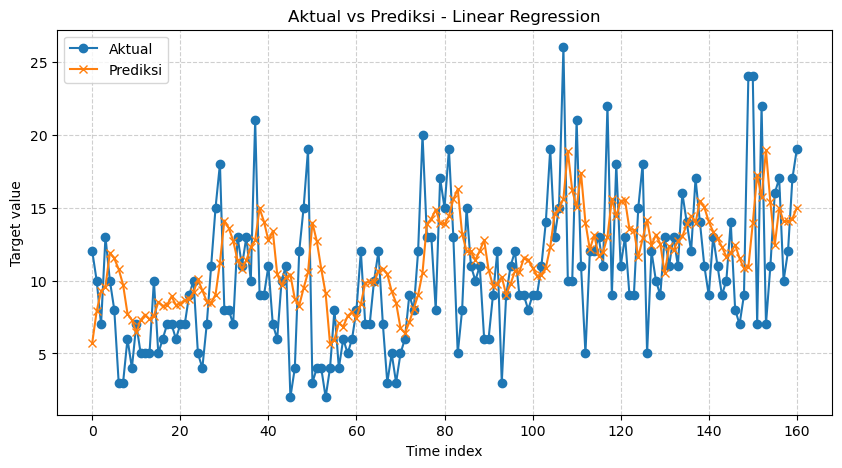

In [334]:
LinearRegression_70 = LinearRegression()

start_time = time.time()
LinearRegression_70.fit(X_train_70, y_train_70)
end_time = time.time()

trained_models_70["Linear Regression"] = LinearRegression_70
trained_times_70["Linear Regression"] = end_time - start_time

y_pred_LinearRegression_70 = LinearRegression_70.predict(X_test_70)
plot(y_test_70, y_pred_LinearRegression_70)

### S2: 80/20

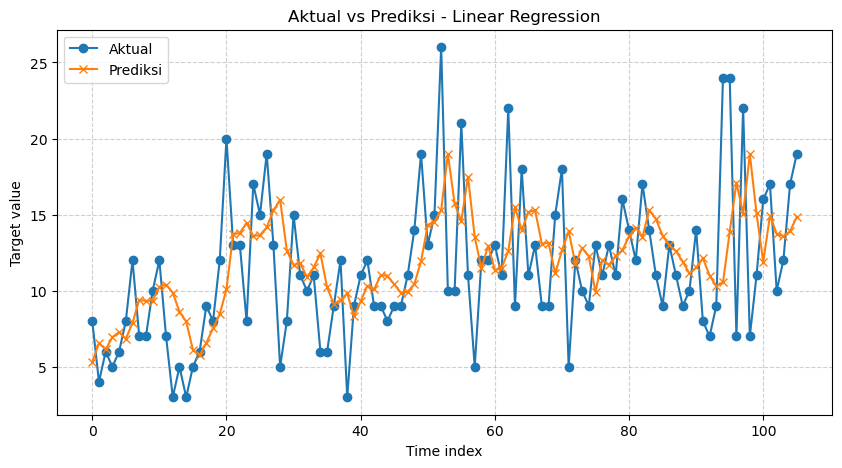

In [335]:
LinearRegression_80 = LinearRegression()

start_time = time.time()
LinearRegression_80.fit(X_train_80, y_train_80)
end_time = time.time()

trained_models_80["Linear Regression"] = LinearRegression_80
trained_times_80["Linear Regression"] = end_time - start_time

y_pred_LinearRegression_80 = LinearRegression_80.predict(X_test_80)
plot(y_test_80, y_pred_LinearRegression_80)

## Gradient Boosting

### S1: 70/30

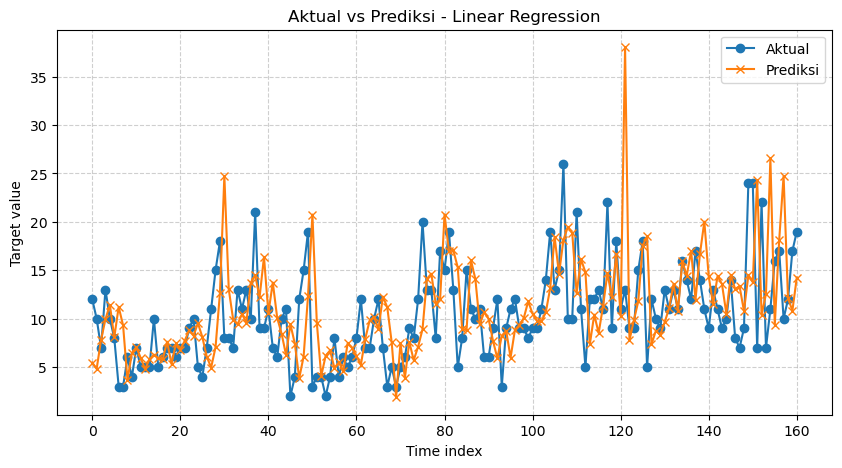

In [336]:
GradientBoostingRegressor_70 = GradientBoostingRegressor(random_state=42)

start_time = time.time()
GradientBoostingRegressor_70.fit(X_train_70, y_train_70)
end_time = time.time()

trained_models_70["Gradient Boosting"] = GradientBoostingRegressor_70
trained_times_70["Gradient Boosting"] = end_time - start_time

y_pred_GradientBoostingRegressor_70 = GradientBoostingRegressor_70.predict(X_test_70)
plot(y_test_70, y_pred_GradientBoostingRegressor_70)

### S2: 80/20

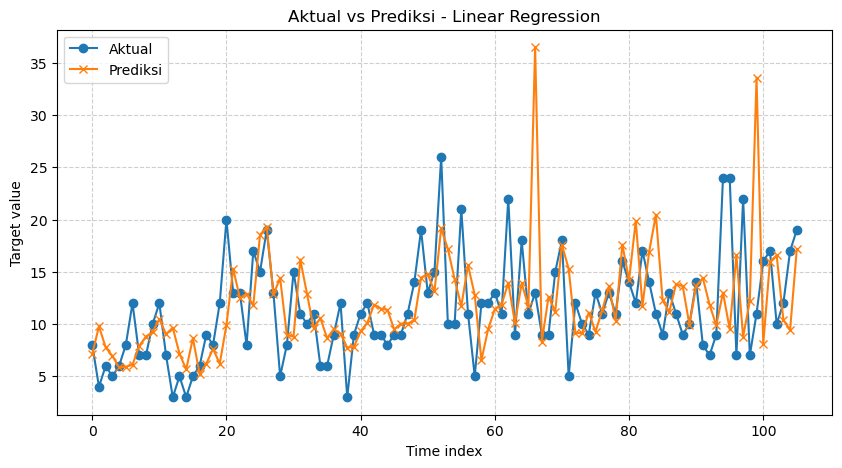

In [337]:
GradientBoostingRegressor_80 = GradientBoostingRegressor(random_state=42)

start_time = time.time()
GradientBoostingRegressor_80.fit(X_train_80, y_train_80)
end_time = time.time()

trained_models_80["Gradient Boosting"] = GradientBoostingRegressor_80
trained_times_80["Gradient Boosting"] = end_time - start_time

y_pred_GradientBoostingRegressor_80 = GradientBoostingRegressor_80.predict(X_test_80)
plot(y_test_80, y_pred_GradientBoostingRegressor_80)

## ADA Boost

### S1: 70/30

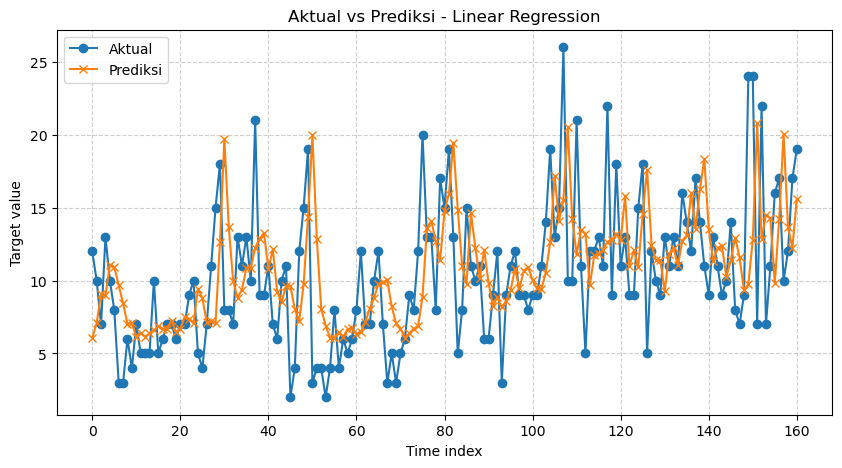

In [338]:
AdaBoostRegressor_70 = AdaBoostRegressor(learning_rate= 0.002, random_state=42, n_estimators=100)

start_time = time.time()
AdaBoostRegressor_70.fit(X_train_70, y_train_70)
end_time = time.time()

trained_models_70["ADA Boost"] = AdaBoostRegressor_70
trained_times_70["ADA Boost"] = end_time - start_time

y_pred_AdaBoostRegressor_70 = AdaBoostRegressor_70.predict(X_test_70)
plot(y_test_70, y_pred_AdaBoostRegressor_70)

### S2: 80/20

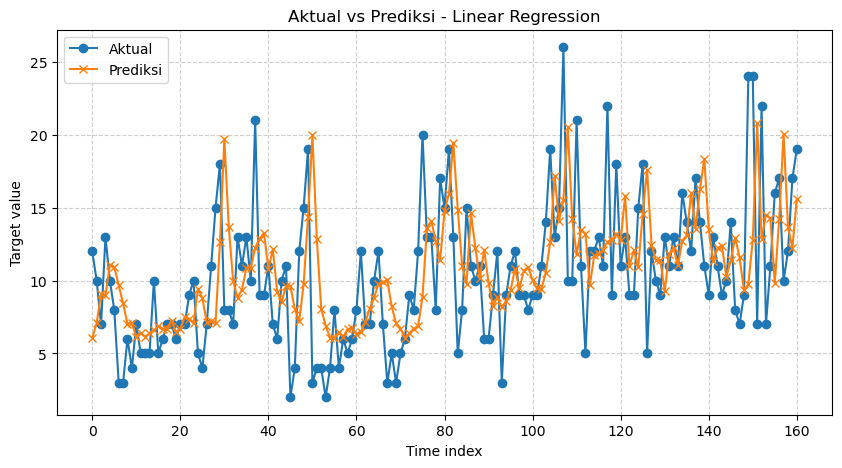

In [339]:
AdaBoostRegressor_80 = AdaBoostRegressor(learning_rate= 0.002, random_state=42, n_estimators=100)

start_time = time.time()
AdaBoostRegressor_80.fit(X_train_70, y_train_70)
end_time = time.time()

trained_models_80["ADA Boost"] = AdaBoostRegressor_80
trained_times_80["ADA Boost"] = end_time - start_time

y_pred_AdaBoostRegressor_80 = AdaBoostRegressor_80.predict(X_test_70)
plot(y_test_70, y_pred_AdaBoostRegressor_80)

## XG Boost

### S1: 70/30

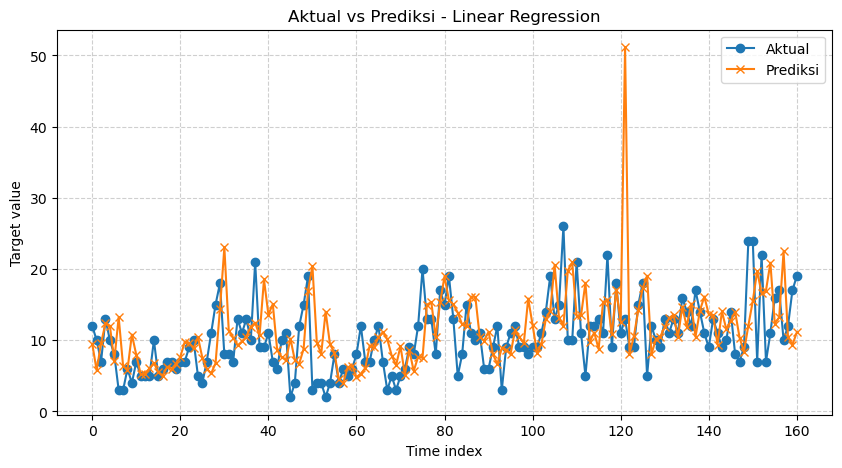

In [340]:
XGBRegressor_70 = XGBRegressor(learning_rate= 0.05, random_state=42, n_estimators=1000, max_depth= 7, reg_lambda=5)

start_time = time.time()
XGBRegressor_70.fit(X_train_70, y_train_70)
end_time = time.time()

trained_models_70["XG Boost"] = XGBRegressor_70
trained_times_70["XG Boost"] = end_time - start_time

y_pred_XGBRegressor_70 = XGBRegressor_70.predict(X_test_70)
plot(y_test_70, y_pred_XGBRegressor_70)

### S2: 80/20

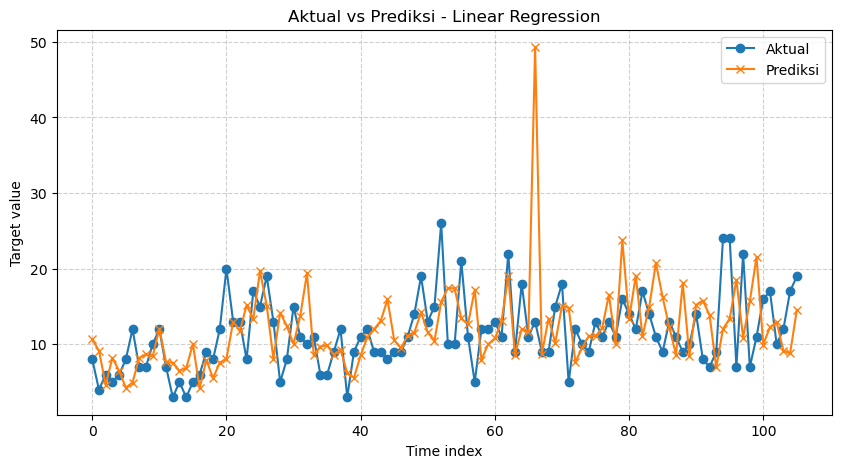

In [341]:
XGBRegressor_80 = XGBRegressor(learning_rate= 0.05, random_state=42, n_estimators=1000, max_depth= 7, reg_lambda=5)

start_time = time.time()
XGBRegressor_80.fit(X_train_80, y_train_80)
end_time = time.time()

trained_models_80["XG Boost"] = XGBRegressor_80
trained_times_80["XG Boost"] = end_time - start_time

y_pred_XGBRegressor_80 = XGBRegressor_80.predict(X_test_80)
plot(y_test_80, y_pred_XGBRegressor_80)

## Cat Boost

### S1: 70/30

### S2: 80/20

## Light GBM

### S1: 70/30

### S2: 80/20

## SVR

### S1: 70/30

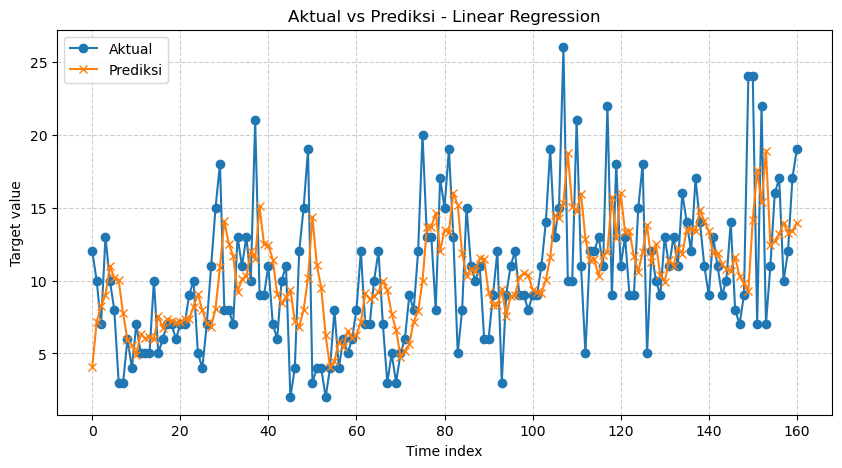

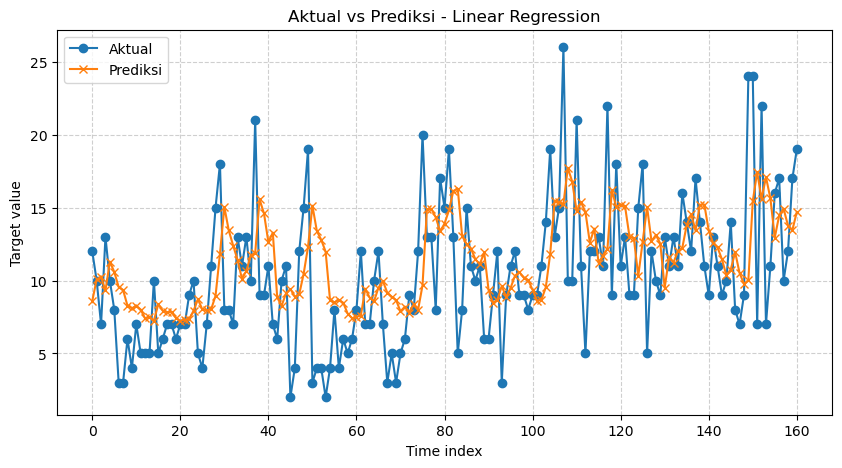

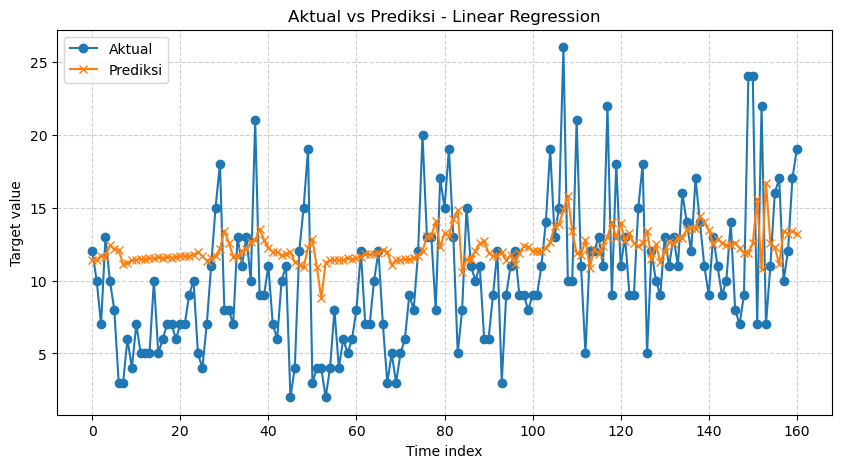

In [342]:
# ============ Definisi model ============
models = {
    "SVR Linear": SVR(kernel="linear", C=1.0, epsilon=0.2),
    "SVR RBF":    SVR(kernel="rbf", C=1.0, gamma="scale", epsilon=0.2),
    "SVR Polynomial": SVR(kernel="poly", degree=3, C=1.0, epsilon=0.1),
}

for name, model in models.items():
    # param string sesuai kernel
    params = model.get_params()
    if model.kernel == "linear":
        param_str = f"kernel={params['kernel']}, C={params['C']}, epsilon={params['epsilon']}"
    elif model.kernel == "rbf":
        param_str = f"kernel={params['kernel']}, C={params['C']}, epsilon={params['epsilon']}, gamma={params['gamma']}"
    elif model.kernel == "poly":
        param_str = (f"kernel={params['kernel']}, degree={params['degree']}, "
                     f"C={params['C']}, epsilon={params['epsilon']}, "
                     f"gamma={params['gamma']}, coef0={params['coef0']}")
    else:
        param_str = str(params)

    start_time = time.time()
    model.fit(X_train_70, y_train_70)
    end_time = time.time()

    trained_models_70[name] = model
    trained_times_70[name] = end_time - start_time

    y_pred = model.predict(X_test_70)
    plot(y_test_70, y_pred)


### S2: 80/20

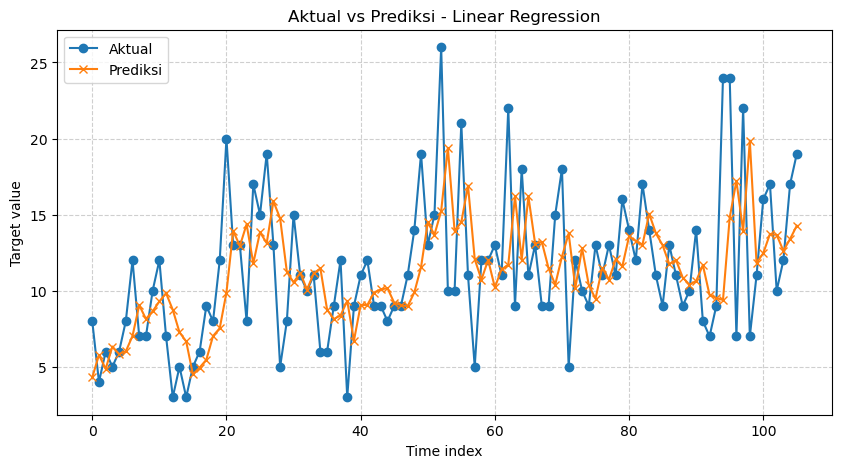

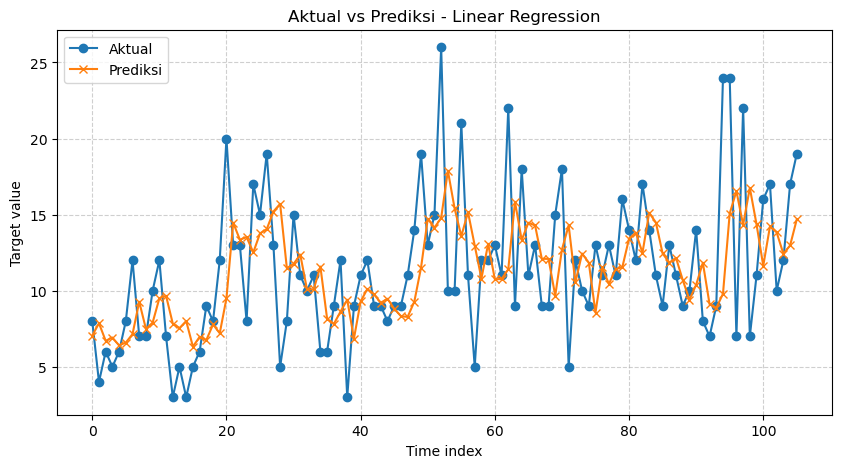

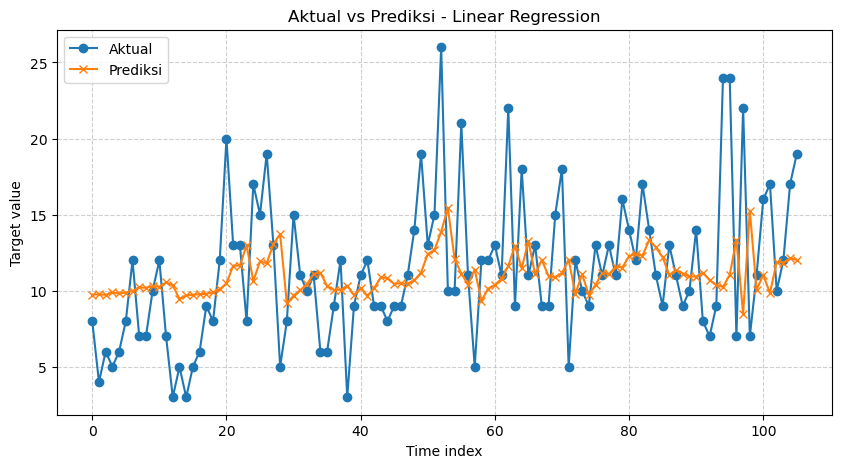

In [343]:
# ============ Definisi model ============
models = {
    "SVR Linear": SVR(kernel="linear", C=1.0, epsilon=0.2),
    "SVR RBF":    SVR(kernel="rbf", C=1.0, gamma="scale", epsilon=0.2),
    "SVR Polynomial": SVR(kernel="poly", degree=3, C=1.0, epsilon=0.1),
}

for name, model in models.items():
    # param string sesuai kernel
    params = model.get_params()
    if model.kernel == "linear":
        param_str = f"kernel={params['kernel']}, C={params['C']}, epsilon={params['epsilon']}"
    elif model.kernel == "rbf":
        param_str = f"kernel={params['kernel']}, C={params['C']}, epsilon={params['epsilon']}, gamma={params['gamma']}"
    elif model.kernel == "poly":
        param_str = (f"kernel={params['kernel']}, degree={params['degree']}, "
                     f"C={params['C']}, epsilon={params['epsilon']}, "
                     f"gamma={params['gamma']}, coef0={params['coef0']}")
    else:
        param_str = str(params)

    # waktu training
    start_time = time.time()
    model.fit(X_train_80, y_train_80)
    end_time = time.time()

    trained_models_80[name] = model
    trained_times_80[name] = end_time - start_time

    y_pred = model.predict(X_test_80)
    plot(y_test_80, y_pred)

# MODEL EVALUATION

In [344]:
rows_70 = []
rows_80 = []

def evaluate(name, model, X_test, y_test, rows, train_time):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    rows.append({
        "Algoritma": name,
        "Nilai Parameter Kernel": model if "SVR" in name else None,
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4),
        "MAPE": round(mape, 4),
        "R²": round(r2, 4),
        "Waktu Pelatihan": round(train_time, 4)
    })


for name, model in trained_models_70.items():
    train_time = trained_times_70.get(name) 
    evaluate(name, model, X_test_70, y_test_70, rows_70, train_time)

for name, model in trained_models_80.items():
    train_time = trained_times_80.get(name) 
    evaluate(name, model, X_test_80, y_test_80, rows_80, train_time)

import pandas as pd
df_70 = pd.DataFrame(rows_70)
df_80 = pd.DataFrame(rows_80)

print("=== Hasil 70% ===")
print(df_70.to_string(index=False))
print("\n\n")
print("\n=== Hasil 80% ===")
print(df_80.to_string(index=False))

=== Hasil 70% ===
        Algoritma            Nilai Parameter Kernel    MAE   RMSE   MAPE      R²  Waktu Pelatihan
Linear Regression                              None 3.6896 4.6442 0.5204  0.0660           0.0026
Gradient Boosting                              None 4.1499 5.7525 0.5285 -0.4329           0.0696
        ADA Boost                              None 3.6590 4.8549 0.4856 -0.0206           0.1622
         XG Boost                              None 4.1259 6.0852 0.5615 -0.6035           0.5575
       SVR Linear SVR(epsilon=0.2, kernel='linear') 3.5026 4.5458 0.4492  0.1052           0.0259
          SVR RBF                  SVR(epsilon=0.2) 3.7022 4.6714 0.5247  0.0551           0.0040
   SVR Polynomial                SVR(kernel='poly') 4.1547 5.0499 0.6342 -0.1043           0.0898




=== Hasil 80% ===
        Algoritma            Nilai Parameter Kernel    MAE   RMSE   MAPE      R²  Waktu Pelatihan
Linear Regression                              None 3.5183 4.5888 0.3932  0.07

## MAE

### S1: 70/30

In [345]:
rows_mae_70 = []

def evaluate_mae(name, model, X_test, y_test, rows, scenario):
    from sklearn.metrics import mean_absolute_error
    y_pred = model.predict(X_test)
    rows.append({
        "Scenario": scenario,
        "Algoritma": name,
        "MAE": round(mean_absolute_error(y_test, y_pred), 4)
    })

for name, model in trained_models_70.items():
    evaluate_mae(name, model, X_test_70, y_test_70, rows_mae_70, "70%")

import pandas as pd
df_mae_70 = pd.DataFrame(rows_mae_70)
print(df_mae_70.to_string(index=False))

Scenario         Algoritma    MAE
     70% Linear Regression 3.6896
     70% Gradient Boosting 4.1499
     70%         ADA Boost 3.6590
     70%          XG Boost 4.1259
     70%        SVR Linear 3.5026
     70%           SVR RBF 3.7022
     70%    SVR Polynomial 4.1547


### S2: 80/20

In [346]:
rows_mae_80 = []

def evaluate_mae(name, model, X_test, y_test, rows, scenario):
    from sklearn.metrics import mean_absolute_error
    y_pred = model.predict(X_test)
    rows.append({
        "Scenario": scenario,
        "Algoritma": name,
        "MAE": round(mean_absolute_error(y_test, y_pred), 4)
    })

for name, model in trained_models_80.items():
    evaluate_mae(name, model, X_test_80, y_test_80, rows_mae_80, "80%")

import pandas as pd
df_mae_80 = pd.DataFrame(rows_mae_80)
print(df_mae_80.to_string(index=False))

Scenario         Algoritma    MAE
     80% Linear Regression 3.5183
     80% Gradient Boosting 3.9558
     80%         ADA Boost 3.6763
     80%          XG Boost 4.5308
     80%        SVR Linear 3.4774
     80%           SVR RBF 3.4453
     80%    SVR Polynomial 3.6031


## RMSE

### S1: 70/30

In [347]:
rows_rmse_70 = []  

def evaluate_rmse(name, model, X_test, y_test, rows, scenario):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rows.append({
        "Scenario": scenario,
        "Algoritma": name,
        "RMSE": round(rmse, 4)
    })

for name, model in trained_models_70.items():
    evaluate_rmse(name, model, X_test_70, y_test_70, rows_rmse_70, "70%")

df_rmse_70 = pd.DataFrame(rows_rmse_70)
print(df_rmse_70.to_string(index=False))

Scenario         Algoritma   RMSE
     70% Linear Regression 4.6442
     70% Gradient Boosting 5.7525
     70%         ADA Boost 4.8549
     70%          XG Boost 6.0852
     70%        SVR Linear 4.5458
     70%           SVR RBF 4.6714
     70%    SVR Polynomial 5.0499


### S2: 80/20

In [348]:
rows_rmse_80 = []  # reset tabel khusus 80%
 

def evaluate_rmse(name, model, X_test, y_test, rows, scenario):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rows.append({
        "Scenario": scenario,
        "Algoritma": name,
        "RMSE": round(rmse, 4)
    })

for name, model in trained_models_80.items():
    evaluate_rmse(name, model, X_test_80, y_test_80, rows_rmse_80, "80%")

df_rmse_80 = pd.DataFrame(rows_rmse_80)
print(df_rmse_80.to_string(index=False))

Scenario         Algoritma   RMSE
     80% Linear Regression 4.5888
     80% Gradient Boosting 5.6608
     80%         ADA Boost 4.8968
     80%          XG Boost 6.3610
     80%        SVR Linear 4.6212
     80%           SVR RBF 4.5178
     80%    SVR Polynomial 4.7480


## MAPE

### S1: 70/30

In [349]:
rows_mape_70 = [] 

def evaluate_mape(name, model, X_test, y_test, rows, scenario):
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rows.append({
        "Scenario": scenario,
        "Algoritma": name,
        "MAPE": round(mape, 4)
    })

# evaluasi semua model terlatih 70% pakai data 70%
for name, model in trained_models_70.items():
    evaluate_mape(name, model, X_test_70, y_test_70, rows_mape_70, "70%")

df_mape_70 = pd.DataFrame(rows_mape_70)
print(df_mape_70.to_string(index=False))

Scenario         Algoritma   MAPE
     70% Linear Regression 0.5204
     70% Gradient Boosting 0.5285
     70%         ADA Boost 0.4856
     70%          XG Boost 0.5615
     70%        SVR Linear 0.4492
     70%           SVR RBF 0.5247
     70%    SVR Polynomial 0.6342


### S2: 80/20

In [350]:
rows_mape_80 = []

def evaluate_mape(name, model, X_test, y_test, rows, scenario):
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rows.append({
        "Scenario": scenario,
        "Algoritma": name,
        "MAPE": round(mape, 4)
    })

for name, model in trained_models_80.items():
    evaluate_mape(name, model, X_test_80, y_test_80, rows_mape_80, "80%")

df_mape_80 = pd.DataFrame(rows_mape_80)
print(df_mape_80.to_string(index=False))

Scenario         Algoritma   MAPE
     80% Linear Regression 0.3932
     80% Gradient Boosting 0.4124
     80%         ADA Boost 0.3934
     80%          XG Boost 0.4709
     80%        SVR Linear 0.3670
     80%           SVR RBF 0.3679
     80%    SVR Polynomial 0.3961


## R-squared

### S1: 70/30

In [351]:
rows_r2_70 = []  # reset tabel khusus 70%

def evaluate_r2(name, model, X_test, y_test, rows, scenario):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rows.append({
        "Scenario": scenario,
        "Algoritma": name,
        "R²": round(r2, 4)
    })

# evaluasi semua model terlatih 70% pakai data 70%
for name, model in trained_models_70.items():
    evaluate_r2(name, model, X_test_70, y_test_70, rows_r2_70, "70%")

df_r2_70 = pd.DataFrame(rows_r2_70)
print(df_r2_70.to_string(index=False))

Scenario         Algoritma      R²
     70% Linear Regression  0.0660
     70% Gradient Boosting -0.4329
     70%         ADA Boost -0.0206
     70%          XG Boost -0.6035
     70%        SVR Linear  0.1052
     70%           SVR RBF  0.0551
     70%    SVR Polynomial -0.1043


### S2: 80/20

In [352]:
rows_r2_80 = [] 

def evaluate_r2(name, model, X_test, y_test, rows, scenario):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rows.append({
        "Scenario": scenario,
        "Algoritma": name,
        "R²": round(r2, 4)
    })

for name, model in trained_models_80.items():
    evaluate_r2(name, model, X_test_80, y_test_80, rows_r2_80, "80%")

df_r2_80 = pd.DataFrame(rows_r2_80)
print(df_r2_80.to_string(index=False))

Scenario         Algoritma      R²
     80% Linear Regression  0.0724
     80% Gradient Boosting -0.4116
     80%         ADA Boost -0.0562
     80%          XG Boost -0.7823
     80%        SVR Linear  0.0593
     80%           SVR RBF  0.1009
     80%    SVR Polynomial  0.0070


# Export Requirements.txt

In [353]:
import pkg_resources

packages = [
    'pandas',
    'scikit-learn',
]

with open("lukas_requirements.txt", "w") as f:
    for pkg in packages:
        try:
            version = pkg_resources.get_distribution(pkg).version
            f.write(f"{pkg}=={version}\n")
        except pkg_resources.DistributionNotFound:
            print(f"Package {pkg} not found in the environment.")
